# Reinforment Learning Procedure

## Procedure

The learner is a logistic function: $P(isEarthQuake\big|x) = \frac{\exp(u)}{\exp(-u) + \exp(u)}$ where $u = w^Tx + b$. The update procedure is as the following:

1. Select several time series from the training data.
2. Use the existing learner to predict output.
3. If the data is from Human, the return will be 1 if the output is no earthquake and 0 otherwise. If the data is from ShakeTable, the return will be -1 * duration where duration is the time when it reports earthquake.
4. Update w and b


In [55]:
import json
import matplotlib.pyplot as plt
import numpy as np
%pylab inline
def get_data(data):
    '''
    get the timestamp and 3-component acceleration data. 
    '''
    # read in x, y, z data
    x = data['data']['x']
    y = data['data']['y']
    z = data['data']['z']

    # calculate the timestamp
    # get the start time
    t0 = data['header']['starttime']
    npoints = len(x)
    sampling_rate = data['header']['sampling_rate']
    
    # get the end time 
    t1 = t0 + npoints / sampling_rate
    
    # form the timestamp
    t = [t0 + tmp/sampling_rate for tmp in range(0, npoints)]
    
    # station latitude and long
    return t, x, y, z

Populating the interactive namespace from numpy and matplotlib


In [56]:
import os
import random
def Sampling(label = None):
    '''
    Draw a sample from data
    
    Args:
    label: boolean, the label of the sample, 1 if shaketable, 0 if human
    
    Returns:
    t     : 1d array, time.
    x     : 1d array, x.
    y     : 1d array, y orthogonal to x.
    z     : 1d array, z (vertical).
    label : boolean.
    '''
    rng = random.Random()
    if label is None:
        label = (rng.random() > 0.5)
    if label:
        path = '../../data/EQ/shake_table/'
    else:
        path = '../../data/Human/'
    files = os.listdir(path)
    oneFile = path + rng.sample(files, 1)[0]
    data = json.load(open('../../data/EQ/simulated/12951_M5.1_1396066202.json', 'rb'))
    t, x, y, z = get_data(data)
    return(t, x, y, z, label, oneFile)
t, x, y, z, label, filename = Sampling()
print(label)
print(filename)


False
../../data/Human/355972051124569_1417367761.json


In [57]:
def LogisticProb(w, b, sequence):
    '''
    Give prediction
    '''
    assert(len(w) == len(sequence))
    assert(isinstance(b, float))
    u = sum(w*sequence)/np.sqrt(sum(sequence * sequence)) - b
    #return(np.exp(u)/(np.exp(u) + np.exp(-u)))
    return(u)
    
#assert(Predict(np.ones((10)), 10., np.ones((10))) == 0)

True
../../data/EQ/shake_table/trial162_phone1.json


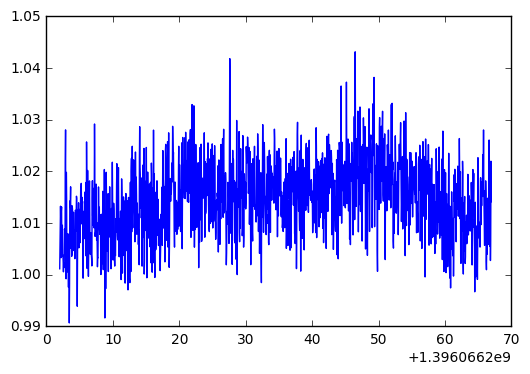

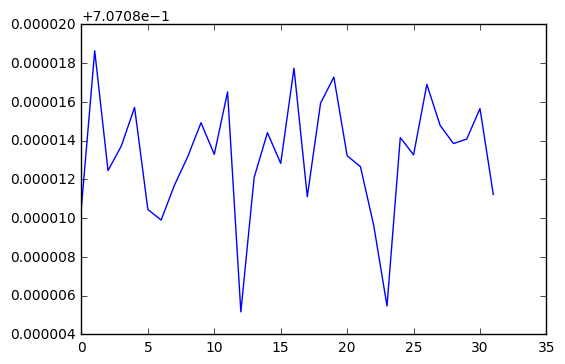

In [66]:
def PredictSeq(w, b, data, noverlap = 0):
    '''
    Predict a overall sequence
    '''
    k = len(w)
    assert(noverlap < k)
    assert(noverlap >= 0)
    assert(isinstance(noverlap, int))
    heads = np.arange(0, len(data) - k, k - noverlap)
    prob = np.zeros(len(heads))
    for i in range(len(heads)):
        head = heads[i]
        prob[i] = LogisticProb(w, b, np.array(data[head:(head + k)]))
    return(prob)
t, x, y, z, label, filename = Sampling()
print(label)
print(filename)
w = np.ones(50)/ 10
b = -0.
prob = PredictSeq(w, b, z)
plt.figure()
plt.plot(t, z)
plt.figure()
plt.plot(prob)

In [ ]:
def Update():
    '''
    Update w and b
    '''
    
    